In [3]:
import pandas as pd
import networkx as nx
from tqdm.auto import tqdm, trange
import pulp


In [2]:
!pip install pulp

     |████████████████████████████████| 14.2 MB 185 kB/s eta 0:00:01


# Load and filter data 

In [21]:
df = pd.read_csv("category.csv", sep="|", names=["child", "parant"], header=None, error_bad_lines=False)

In [22]:
num = pd.read_csv("num_pages_per_category.csv", sep=";", error_bad_lines=False)

In [7]:
num.fillna(0, inplace=True)

In [8]:
num_pages = {x:int(y) for i, (x,y) in num.iterrows()}

In [24]:
df.dropna(inplace=True)

In [25]:
df_filtered = df[df.parant.str.contains("[А-Яа-я]+:") != True] #1435798 #1324222 

In [26]:
df_filtered = df_filtered[df_filtered.parant.str.contains("Страницы,_") != True] # 1303093

In [27]:
df_filtered = df_filtered[df_filtered.parant.str.contains("Статьи_проекта_") != True] 
df_filtered = df_filtered[df_filtered.parant.str.contains("Хорошие_статьи") != True] 
df_filtered = df_filtered[df_filtered.parant.str.contains("Перенаправления,_") != True] # 1162034
df_filtered = df_filtered[df_filtered.parant.str.contains("Избранные_списки_") != True]
df_filtered = df_filtered[df_filtered.parant.str.contains("Избранные_статьи_") != True]
df_filtered = df_filtered[df_filtered.parant.str.contains("Списки_проекта") != True] #1157705
df_filtered = df_filtered[df_filtered.parant.str.contains("Добротные_статьи_") != True]
df_filtered = df_filtered[df_filtered.parant.str.contains("Статьи") != True] # 1143030
df_filtered = df_filtered[df_filtered.parant.str.contains("Незавершённые_") != True] # 1143030

In [29]:
G = nx.DiGraph()
for i, gr in tqdm(df_filtered.groupby('child')):
    
    vertex = set()
    edges = []
    for i, r in gr.iterrows():
        
        G.add_node(r.parant, color="white",)
        G.add_node(r.child, color="white",)
        G.add_edge(r.parant, r.child)


  0%|          | 0/499446 [00:00<?, ?it/s]

# Selecting subgraph

In [65]:
G_ = G.copy()

In [66]:
for node in G_.nodes:
    try:
        G_.remove_edge(node, node)
    except:
        continue

In [67]:
tree_depth_counter = 0
nodes = []

start_node = ""

#custom dfs with cycle detection
def dfs(Gn, node, max_depth):
    global nodes, tree_depth_counter, start_node
    
    nodes.append(node)    
    Gn.nodes[node]['color'] = 'gray'
    tree_depth_counter += 1
    if tree_depth_counter == max_depth:
        tree_depth_counter -= 1
        return
    for v in Gn.successors(node):
        if Gn.nodes[v]['color'] == 'white':
            dfs(Gn, v, max_depth)
        elif Gn.nodes[v]['color'] == 'gray':
            continue
    tree_depth_counter -= 1

In [68]:
# getting subgrapg starting with some category

nodes = []
start_node = "Точные_науки"

dfs(G_, start_node, max_depth=4)

In [69]:
len(nodes)

932

In [70]:
subG = nx.DiGraph(G_.subgraph(nodes))

In [71]:
# get rid of cycles by removeing last edge in cycle

while nx.algorithms.is_directed_acyclic_graph(subG) == False:
    subG.remove_edge(*nx.algorithms.cycles.find_cycle(subG)[-1])

In [72]:
# applying transitive reduction to remove redundant edges
subG = nx.algorithms.dag.transitive_reduction(subG)

In [73]:
# get sure that graph is still connected
nx.algorithms.is_weakly_connected(subG)

True

In [74]:
# get list of all roots and connect it to artificial root node
roots = []
for n in subG.nodes:
    if len(list(subG.predecessors(n))) == 0:
        roots.append(n)

In [75]:
# if amout of root is imadequativaly high, you'd better to change the root node or depth in dfs, it's ok
# you shold start from 'G_ = G.copy()' cell
roots

['Точные_науки']

In [76]:
subG.add_node("ROOT")
subG.nodes["ROOT"]['pages'] = 0
subG.add_edges_from([("ROOT", x) for x in roots])
subG.add_edge("ROOT", 'ROOT')


In [77]:
num_pages["ROOT"] = 0

In [78]:
nodes = []
for x in list(subG.nodes):
    preds = list(subG.predecessors(x))
    #if len(preds) > 1:
    nodes.append((x, preds[0]))


In [79]:
print(len(nodes))

933


In [80]:
# formulating ILP problem to get tree

model = pulp.LpProblem("Tree_prune_problem", pulp.LpMaximize)

links = pulp.LpVariable.dicts("nodes",
                            nodes,
                            lowBound=0,
                            upBound=1,
                            cat='Binary')
#objective
model += pulp.lpSum([links[node, perent] * num_pages[node] for node, perent in nodes])

#for node, perent in nodes:
#    if G.nodes[node]["pages"] < 2:
#        model +=   links[node, perent] == 0
    #model += pulp.lpSum([links[node, perent] for node, perent in nodes if G.nodes[node]["pages"] > 1]) >= 0
#for n in nodes:

# from artificially node root, that conncets subgraphs, we ensure that only one tree is selected (2 because root is connected to itself)
#model += pulp.lpSum([links[node,perent] for node,perent in nodes if perent == "ROOT"]) == 2

#connectivity
for n in nodes:
    model += (pulp.lpSum([links[node,perent] for node,perent in nodes if node == n[0]]))\
            - 1/(len(nodes))*\
            (pulp.lpSum([links[node,perent] for node,perent in nodes if perent == n[0]])) >= 0

#window of pages sum
model += pulp.lpSum([links[node, perent] * num_pages[node] for node, perent in nodes]) >= 1
#model += pulp.lpSum([links[node, perent] * G.nodes[node]["pages"] for node, perent in nodes]) <= 500

#window of nodes
model += pulp.lpSum([links[node, perent] for node, perent in nodes]) >= 1
model += pulp.lpSum([links[node, perent] for node, perent in nodes]) <= 1000

# each node has one head
for n in nodes:
    model += pulp.lpSum([links[node, perent] for node, perent in nodes if node == n[0]]) <= 1


# each mode has at least n children
#for n in nodes:
#    model += (pulp.lpSum([links[node, perent] for node, perent in nodes if perent == n[0]])) <= 1

In [81]:
model.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ibuyanov/anaconda3/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/8cb6b4f1c38348388a7f463c06e0e637-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/8cb6b4f1c38348388a7f463c06e0e637-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1874 COLUMNS
At line 10201 RHS
At line 12071 BOUNDS
At line 13005 ENDATA
Problem MODEL has 1869 rows, 933 columns and 5562 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 26969 - 0.01 seconds
Cgl0004I processed model has 238 rows, 857 columns (857 integer (797 of which binary)) and 2780 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.833333
Cbc0038I Pass   1: suminf.    0.50000 (1) obj. -26969 iterations 9
Cbc0038I Solution found of -26969
Cbc0038I 

1

In [82]:
preserved_nodes = []
preserved_edges = []
for node,perent in nodes:
    if links[node,perent].varValue == 1:
        if perent == node:
            continue
        preserved_nodes.append(node)
        preserved_edges.append((perent, node, ))

In [83]:
print(len(preserved_nodes))

906


In [84]:
nG = nx.DiGraph()
nG.add_nodes_from(preserved_nodes)
nG.add_edges_from(preserved_edges)

In [85]:
# check if resulted graph is actually tree
nx.algorithms.tree.recognition.is_tree(nG)

True

In [86]:
nG_ = nG.copy()

In [87]:
def del_node_succ(G, node):
    try:
        s = list(nx.nodes(nx.dfs_tree(nG_, node)))    
        G.remove_nodes_from([node]+s)
    except:
        pass

In [88]:
# cut pages that have less than treshold
PAGE_TRESHOLD = 20
eliminate = [n for n in nG_.nodes if (num_pages[n] < PAGE_TRESHOLD or num_pages[n] > 200) and n != "Точные_науки" and n != "ROOT" ]
for n in eliminate:
    del_node_succ(nG_, n)

In [89]:
len(nG_.nodes)

67

In [94]:
import matplotlib.pyplot as plt
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [97]:
# !pip install pydot
!sudo apt install graphviz

[sudo] password for ibuyanov: 


In [95]:
def plot_tree_numbers(Gs, mapping=None, figsize=(50,50), preserve=None):
    plt.figure(figsize=figsize)
    H = nx.convert_node_labels_to_integers(Gs,)
    mapping = {x:y for x,y in enumerate(Gs.nodes())}
    pos = graphviz_layout(H, prog="dot")
    nx.draw_networkx(H, pos, nodelist=preserve)#pos
    plt.show()
    return mapping

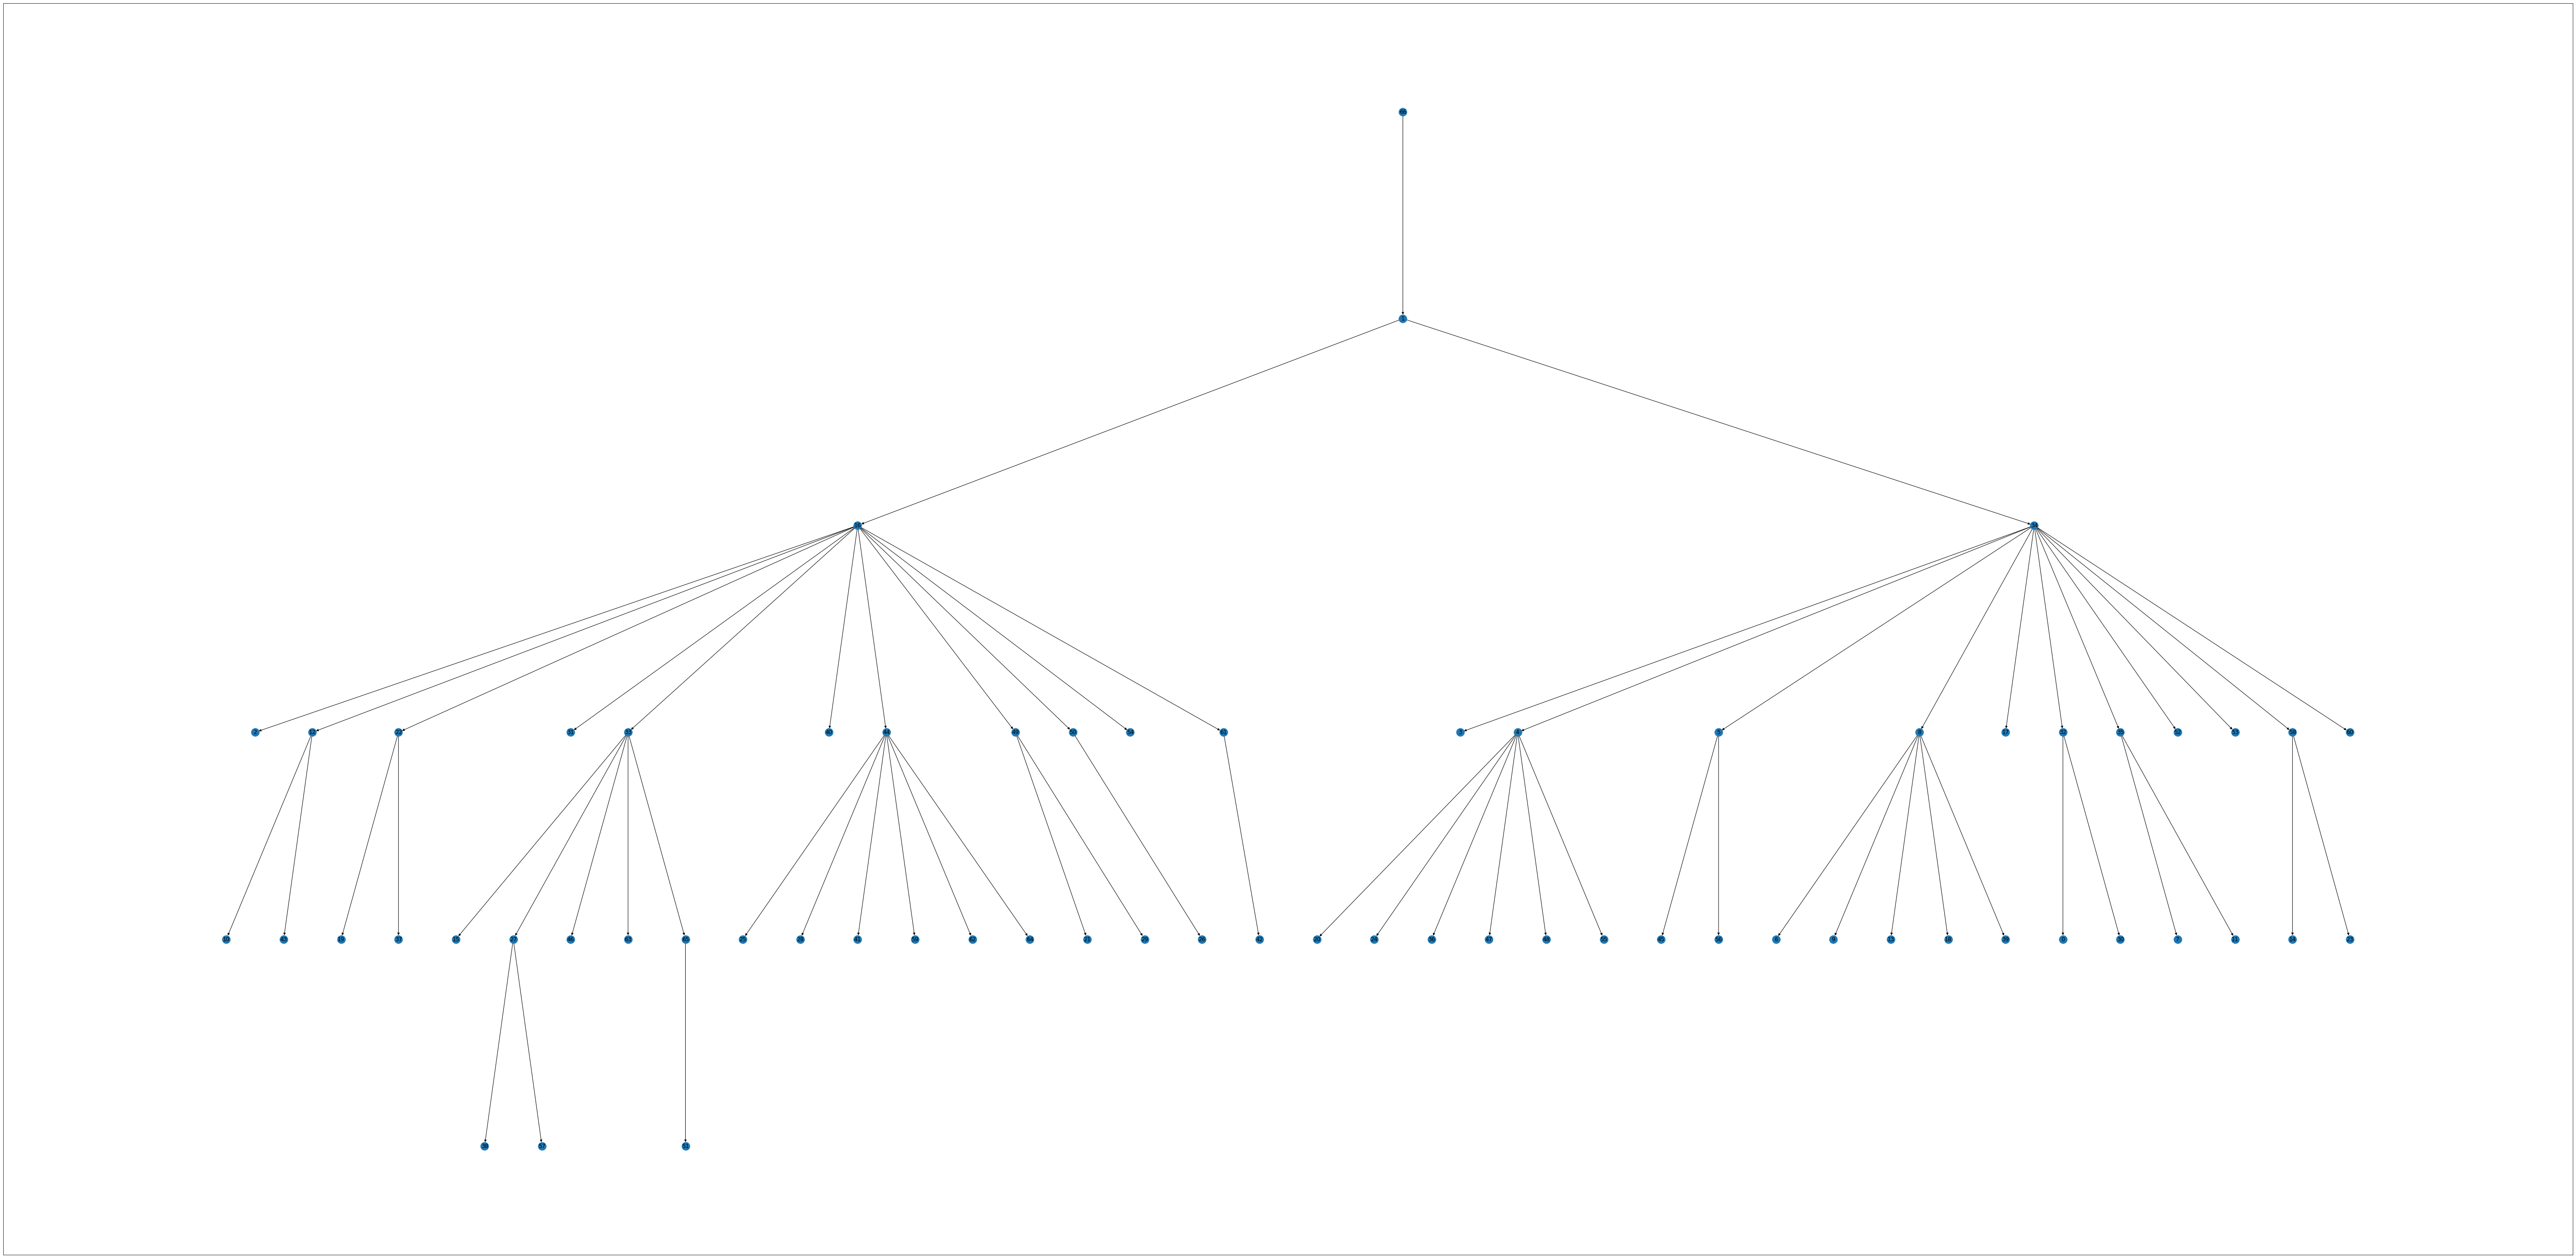

In [98]:
# draw tree and get the dictionary number:name of category
num2label = plot_tree_numbers(nG_, figsize=(100,50))

In [99]:
# remove all nodes that we don't like. 
# ATTANTION: for each node in the list, thier predessesors also will be deleted, so be carefull.
# On the other hand, you don't need to select all node from the branch you want to delete, just its start
# You may do this operation several times
MANUALY_SELECTED = [38,57,51]

eliminate = [num2label[x] for x in MANUALY_SELECTED ]

In [100]:
for n in eliminate:
    del_node_succ(nG_, n)

In [101]:
nG_.remove_node("ROOT")

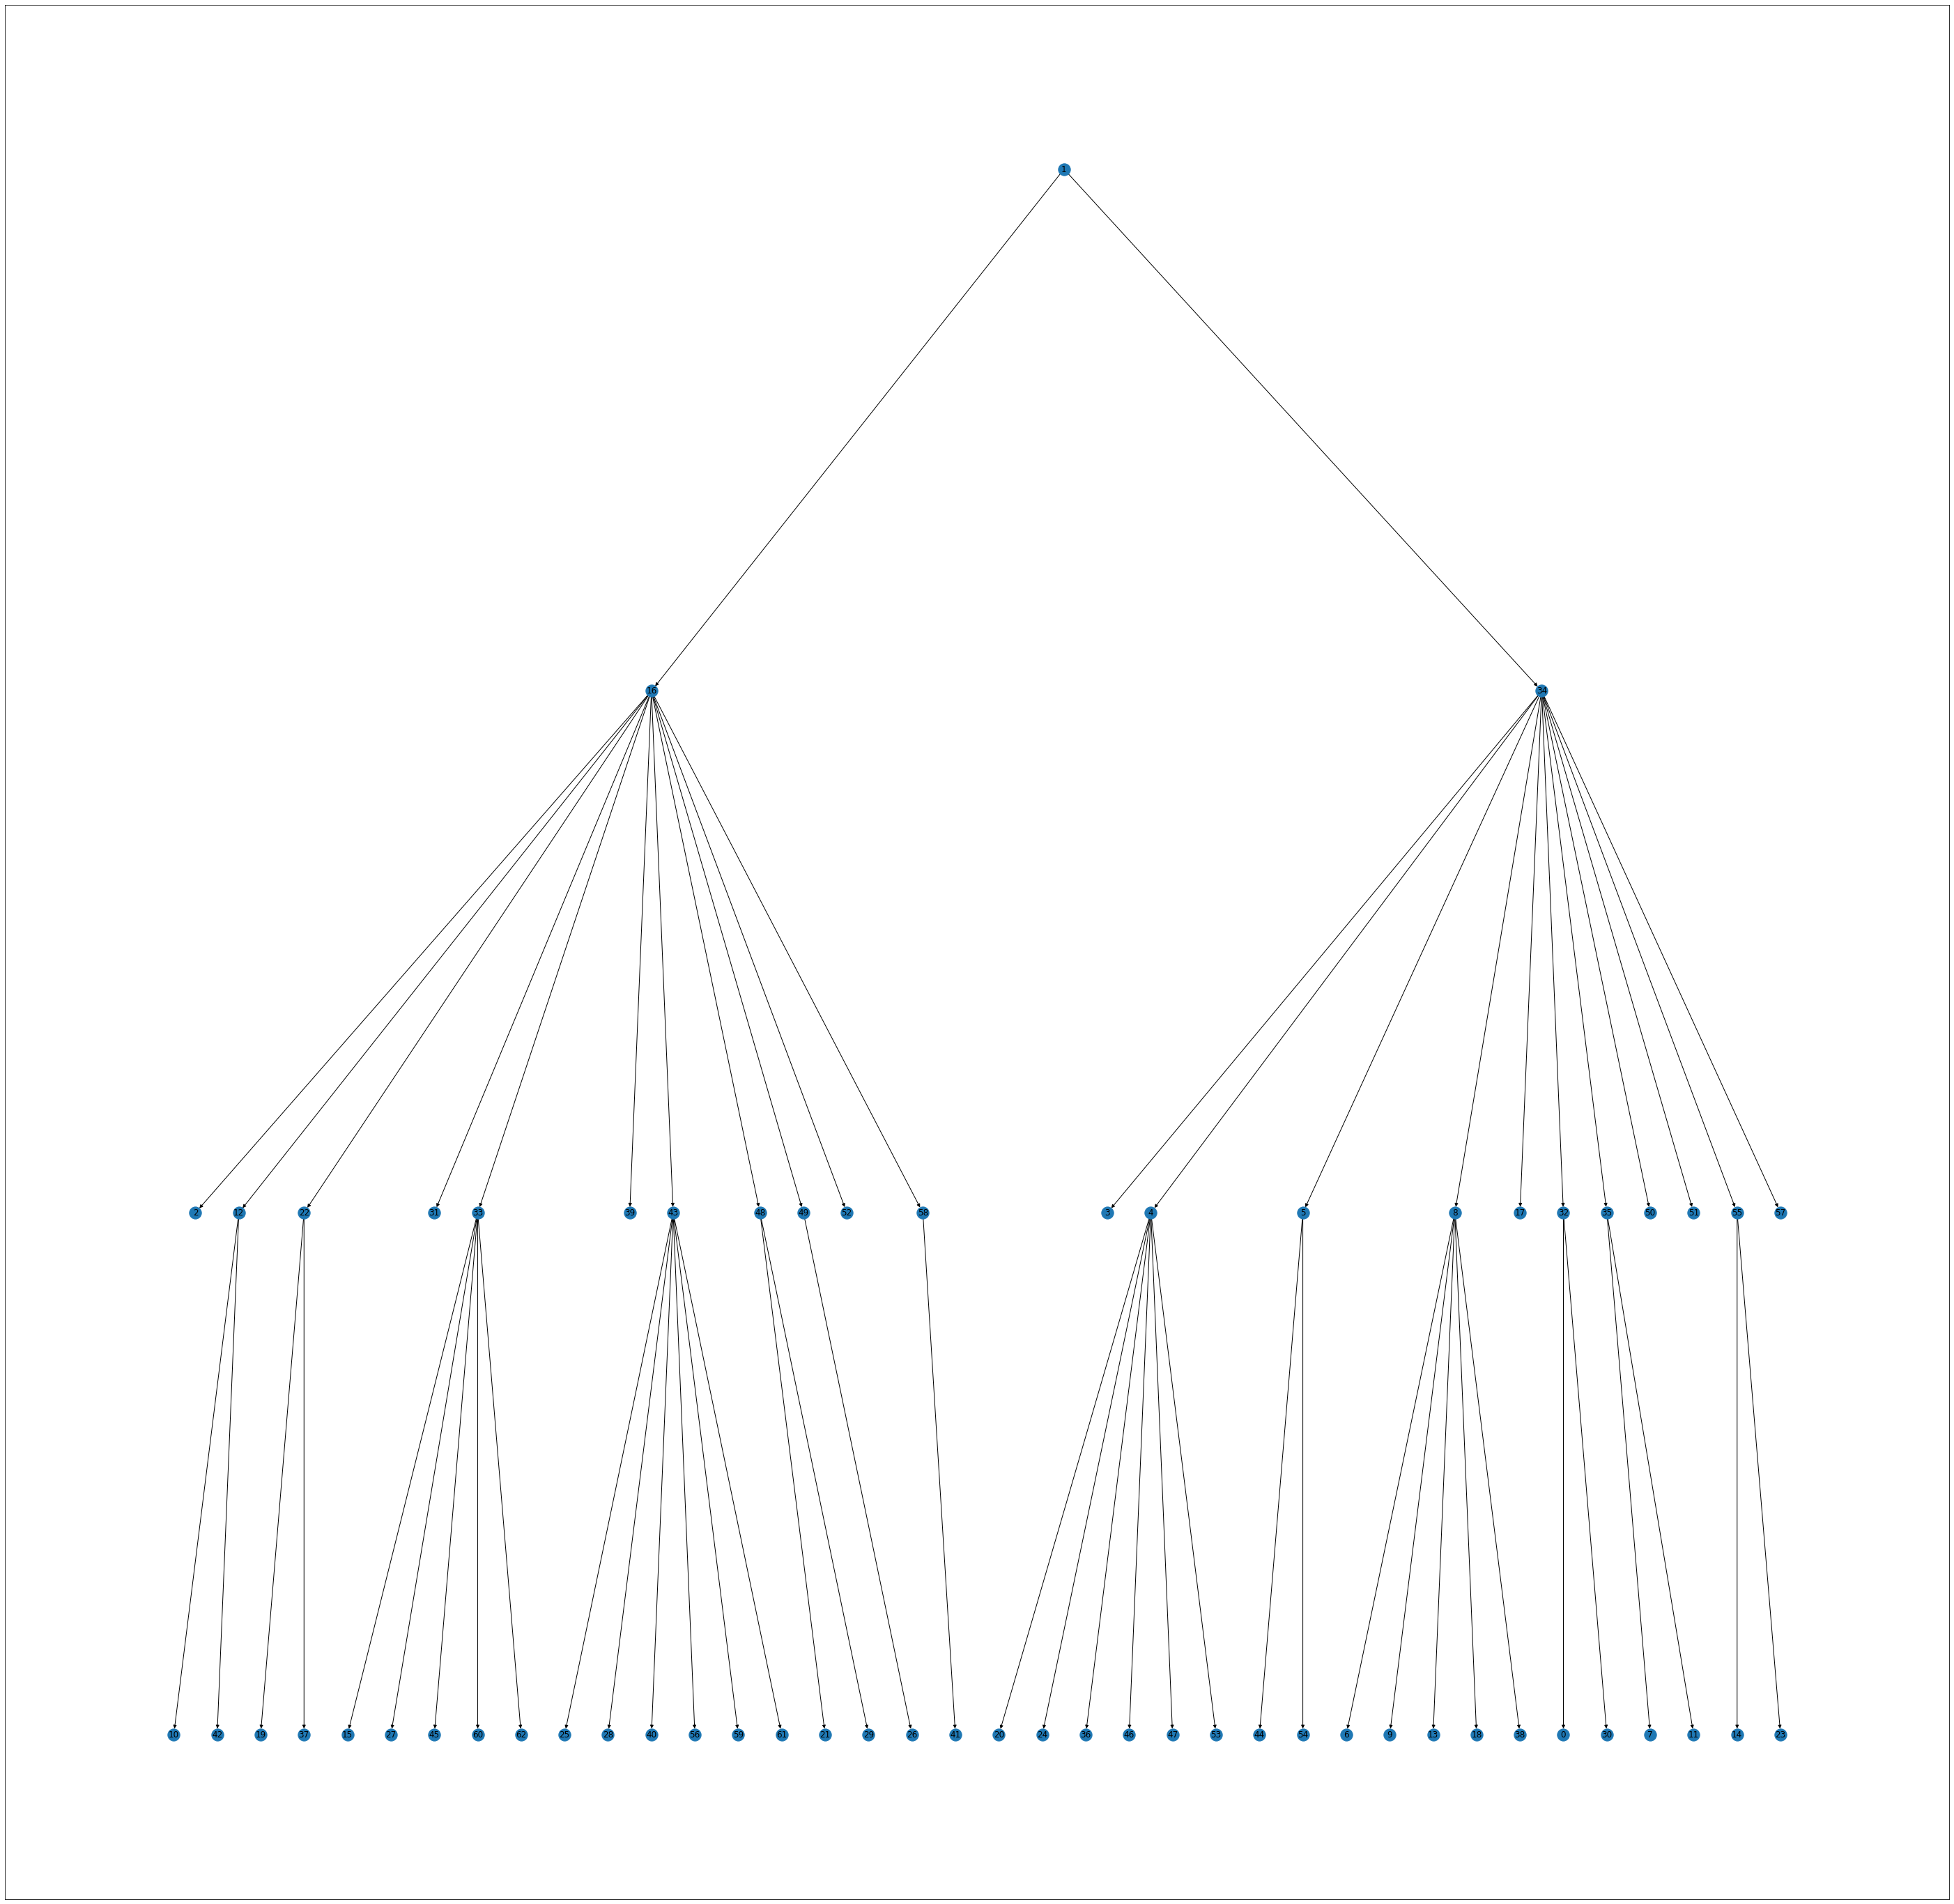

{0: 'Распределённые_вычисления',
 1: 'Точные_науки',
 2: 'Химическая_промышленность',
 3: 'Хемоинформатика',
 4: 'Базы_данных',
 5: 'Теория_информации',
 6: 'Лауреаты_премии_Тьюринга',
 7: 'Поисковые_системы',
 8: 'Премии_в_области_информатики',
 9: 'Лауреаты_премии_Канеллакиса',
 10: 'Лабораторная_посуда',
 11: 'Электронные_документы',
 12: 'Лабораторное_оборудование',
 13: 'Лауреаты_премии_Гёделя',
 14: 'Просвещение',
 15: 'Изотопы',
 16: 'Химия',
 17: 'Биоинформатика',
 18: 'Награждённые_медалью_Джона_фон_Неймана',
 19: 'Нефтехимия',
 20: 'Теоретические_основы_баз_данных',
 21: 'Награждённые_медалью_Пристли',
 22: 'Химическая_технология',
 23: 'Инженерия_знаний',
 24: 'Базы_данных_в_Интернете',
 25: 'Аналитическая_химия',
 26: 'Квантовая_химия',
 27: 'Радиоактивные_элементы',
 28: 'Стереохимия',
 29: 'Лауреаты_премии_Вольфа_(химия)',
 30: 'Параллельные_вычислительные_системы',
 31: 'Химическая_номенклатура',
 32: 'Параллельные_вычисления',
 33: 'Химические_элементы',
 34: 'Информати

In [102]:
plot_tree_numbers(nG_, )

In [103]:
num = []
for node in nG_.nodes:
    num.append(num_pages[node])
    

In [104]:
num.remove(1)

In [105]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

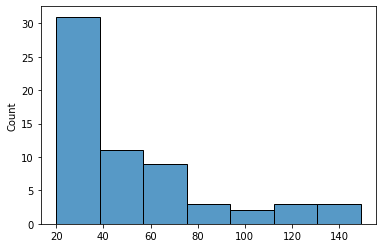

In [111]:
sns.histplot(num)

In [107]:
sum(num)


3135

In [108]:
import numpy as np

np.mean(num)

50.564516129032256

# Write categories into files

In [113]:
store = []
for n in nG_.nodes:
    if n == 'Точные_науки':
        continue
    path = list(nx.all_simple_paths(nG_,"Точные_науки", n))
    if len(path) > 1:
        raise ValueError
    path = path[0]
    store.append('/'.join(path))

In [114]:
store.sort()

In [115]:
len(store)

62

file with hierarcy categories like

category_1/subcategory_2/subcategory_3

In [116]:
with open("categoryies_classes.txt", 'w') as f:
    for l in store:
        f.write(l+"\n")

files with plain categories like

category

category

category

In [117]:
with open("categoryies.txt", 'w') as f:
    for l in nG_.nodes:
        f.write(l+"\n")